In [1]:
# in case we need to look at stuff like stats over labels etc.
%matplotlib inline

# the usual suspects
import numpy as np
import pandas as pd
from xml.etree import ElementTree as ET

# Hacky workaround instead of just writing parse_sfl to file :P
import sys
if sys.version_info[0] < 3:
    from StringIO import StringIO
else:
    from io import StringIO

# get that cool function in here
from sfl_xml2iob import parse_sfl

# starting from the top: go back to this directory
%cd '/Users/sigrid/repos/sflparsing/code/'

/Users/sigrid/repos/sflparsing/code


In [8]:
%%capture --no-stderr --no-display tagged_io
parse_sfl(n=50)

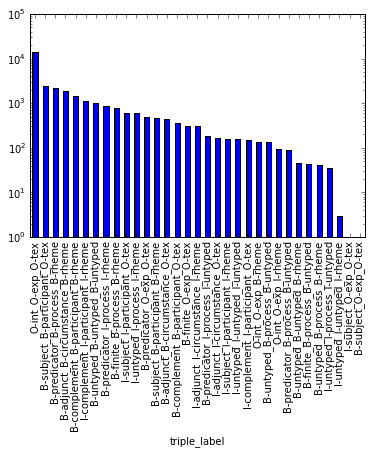

In [158]:
#tagged.show()
cols = ['file_id','cc_num','token','pos','interpersonal','experiential','textual']
tagged = StringIO(tagged_io.stdout)
sfl = pd.read_table(tagged,header=None, names=cols, index_col=2)
sfl['tokenID'] = sfl.index
# ':' is not allowed in feature values
sfl.token = sfl.token.str.replace(':','..')
sfl.pos = sfl.pos.str.replace(':','..') # look into at least 15 bad unique pos-tags

# make a label that's a combination of all three layers

sfl['triple_label'] = sfl.interpersonal+'_'+sfl.experiential+'_'+sfl.textual

to_plot = sfl.groupby('triple_label').count().sort('tokenID',ascending=0).tokenID.plot(
    kind='bar',logy=True)

In [159]:
#tree = ET.ElementTree(file='../data/wsj_2388.xml')
#grammar = tree.find('Grammar')
sfl.triple_label

w143287     B-complement_B-participant_O-tex
w143289       B-predicator_B-process_B-rheme
w143290      B-subject_B-participant_B-rheme
w143296      I-subject_I-participant_I-rheme
w143298      I-subject_I-participant_I-rheme
w143300                    O-int_O-exp_O-tex
w143306                    O-int_O-exp_O-tex
w143307                    O-int_O-exp_O-tex
w143309                    O-int_O-exp_O-tex
w143310                    O-int_O-exp_O-tex
w143311                    O-int_O-exp_O-tex
w143312                    O-int_O-exp_O-tex
w143314                    O-int_O-exp_O-tex
w143315                    O-int_O-exp_O-tex
w143317     B-adjunct_B-circumstance_B-rheme
w143318                    O-int_O-exp_O-tex
w143319                    O-int_O-exp_O-tex
w143320                    O-int_O-exp_O-tex
w143334        B-subject_B-participant_O-tex
w143337           B-finite_B-process_B-rheme
w143338          I-untyped_I-process_I-rheme
w143340       B-predicator_I-process_I-rheme
w143341   

In [27]:
sfl.pos.unique()

array(['WDT', 'VBP', 'PRP$', 'WHNP', 'UH', 'RB', 'ADVP', 'IN', 'NN',
       'INTJ', 'PRP', 'NP', 'CC', 'VBD', 'RP', 'CONJP', 'JJ', 'DT', 'CD',
       'WRB', 'NNP', 'JJR', 'TO', 'VP', 'VBZ', 'WP', 'NNS', 'MD', 'VB',
       'clause class.major', 'QP', 'BES', 'PDT', 'VBN', 'VBG', 'PP', 'XX',
       'X', 'FW', 'WHADVP', 'ADJP', 'HVS', 'UCP', 'NNPS', 'EX', 'JJS',
       'RBR', 'RBS', ',', 'WHADJP', 'clause class.minor', 'GW', 'WHPP',
       'NX', '$', '``', 'NAC', '-LRB-', '..'], dtype=object)

In [160]:
# format to Rungsted input:
def rung_former(df,label_col):
    """Expects a dataframe [hardcoded columns!] and outputs list of labels 
    and vowpalwabbit formatted string with label_col(s?) as label"""
    labels = df[label_col].unique()
    output = ''
    cc_num = 1
    # hacky
    alt = [l for l in ['interpersonal','experiential','textual'] if l!=label_col]
    for i, row in df.iterrows():
        if row.cc_num != cc_num:
            output += '\n'
            cc_num = row.cc_num
        label = row[label_col]
        
        # hacky: comment out one with irelevant namespaces
        #line = "{} '{}|w token={} pos={} |n {} |p alt0={} alt1={} |l label={}\n".format(
        line = "{} '{}|w token={} pos={} |n {} |l alt0={} alt1={} label={}\n".format(
            label,
            i,
            row.token,
            row.pos,
            str(row.cc_num)+'_'+row.tokenID,
            row[alt[0]],                                                                                         
            row[alt[1]],
            # note that this last info should be cheating!
            row[label_col])


        output += line
    return output,labels

# decide how many files are in test-set and exclude them from learning
file_set = sfl.file_id.unique()
train_set = file_set[:-10]
lab = 'triple_label'
to_rungsted_learn,labels = rung_former(sfl[sfl.file_id.isin(train_set)],lab)
to_rungsted_test,_ = rung_former(sfl[~sfl.file_id.isin(train_set)],lab)

print(labels)
#print(to_rungsted)

['B-complement_B-participant_O-tex' 'B-predicator_B-process_B-rheme'
 'B-subject_B-participant_B-rheme' 'I-subject_I-participant_I-rheme'
 'O-int_O-exp_O-tex' 'B-adjunct_B-circumstance_B-rheme'
 'B-subject_B-participant_O-tex' 'B-finite_B-process_B-rheme'
 'I-untyped_I-process_I-rheme' 'B-predicator_I-process_I-rheme'
 'I-complement_I-participant_O-tex' 'B-untyped_B-untyped_B-untyped'
 'I-untyped_I-untyped_I-untyped' 'B-predicator_O-exp_O-tex'
 'B-complement_B-participant_B-rheme' 'I-complement_I-participant_I-rheme'
 'B-adjunct_B-circumstance_O-tex' 'B-finite_O-exp_O-tex'
 'I-adjunct_I-circumstance_I-rheme' 'O-int_O-exp_B-rheme'
 'O-int_O-exp_I-rheme' 'I-subject_I-participant_O-tex'
 'B-predicator_B-process_B-untyped' 'I-adjunct_I-circumstance_O-tex'
 'I-untyped_I-process_I-untyped' 'B-untyped_B-process_B-untyped'
 'B-predicator_I-process_I-untyped' 'B-finite_B-process_B-untyped'
 'B-untyped_B-process_B-rheme' 'B-untyped_B-untyped_B-rheme'
 'I-untyped_I-untyped_I-rheme' 'B-subject_O-e

In [161]:
# write train and test file to absolute path
test_out = open('/Users/sigrid/software/rungsted/rungsted_learning.txt','w')
test_out.write(to_rungsted_learn)
test_out.close()
test_out = open('/Users/sigrid/software/rungsted/rungsted_testing.txt','w')
test_out.write(to_rungsted_test)
test_out.close()
#%cd '/Users/sigrid/software/rungsted/'
#!cat rungsted_testing.txt

In [162]:
# check that both train and test is present
!ls

README.md              data                   rungsted_testing.txt
build                  rungsted               setup.py
build.sh               rungsted_learning.pred valgrind-python.supp
clean.sh               rungsted_learning.txt


In [163]:
# change directory and run rungsted

rung_dir = '/Users/sigrid/software/rungsted/'
rungsted = 'rungsted/labeler.py'
train = 'rungsted_learning.txt'
test = 'rungsted_testing.txt'
pred = 'rungsted_learning.pred'
%cd '/Users/sigrid/software/rungsted/'
%pwd

! python $rungsted --train $train --test $test --passes 5 --predictions $pred --ignore l

/Users/sigrid/software/rungsted
2015-07-10 23:24:26,201 : INFO : Tagger started. 
Called with Namespace(ada_grad=True, append_test=None, audit=False, average=True, confusion_scaling=None, cost_sensitive=False, drop_out=False, final_model=None, hash_bits=None, ignore=['l'], initial_model=None, labels=None, name=None, passes=5, predictions='rungsted_learning.pred', quadratic=[], test='rungsted_testing.txt', train='rungsted_learning.txt')
2015-07-10 23:24:26,434 : INFO : Training data 2637 sentences 33 labels
2015-07-10 23:24:26,464 : INFO : Test data 164 sentences 33 labels
2015-07-10 23:24:26,480 : INFO : Weight vector sizes. Transition=(35, 35). Emission=(1014981,)
[1] train loss=0.3676                                                                         
[2] train loss=0.2693                                                                         
[3] train loss=0.2228                                                                         
[4] train loss=0.1863                    

In [164]:
# look at predictions
!cat rungsted_learning.pred

w1191266	B-subject_B-participant_O-tex	O-int_O-exp_O-tex
w1191267	I-subject_I-participant_O-tex	O-int_O-exp_O-tex
w1191268	I-subject_I-participant_O-tex	O-int_O-exp_O-tex
w1191269	I-subject_I-participant_O-tex	O-int_O-exp_O-tex
w1191273	B-predicator_B-process_B-rheme	B-predicator_B-process_B-rheme
w1191275	O-int_O-exp_O-tex	B-complement_B-participant_B-rheme
w1191277	O-int_O-exp_O-tex	O-int_O-exp_O-tex
w1191279	O-int_O-exp_O-tex	O-int_O-exp_O-tex
w1191280	O-int_O-exp_O-tex	O-int_O-exp_O-tex
w1191281	O-int_O-exp_O-tex	O-int_O-exp_O-tex
w1191285	B-untyped_B-process_B-untyped	O-int_O-exp_O-tex
w1191288	B-predicator_I-process_I-untyped	B-predicator_O-exp_O-tex
w1191289	B-complement_B-participant_O-tex	B-complement_B-participant_B-rheme
w1191290	B-untyped_B-untyped_B-untyped	B-untyped_B-untyped_B-untyped
w1191292	B-predicator_I-process_I-untyped	B-predicator_O-exp_O-tex
w1191293	B-complement_B-participant_O-tex	B-complement_B-participant_B-rheme
w1191296	B-predicator_B-process_B-rheme	B-pre